# PyTorch实战1

> Note: 学习自[子豪同学的B站视频](https://www.bilibili.com/video/av54777178)，源文件来自[子豪同学的GitHub](https://github.com/TommyZihao/zihaopytorch).

> **版权声明：代码修改自上述链接（MIT LICENSE），且我也参考了原始链接（见下）。如有侵权或不当的地方，我将抱以歉意，请尽快联系我。**

## 目标

这次实战的目标是使用Fashion-MINIST数据集做分类任务，期间复习PyTorch的简单用法，主要包括全连接网络，以及几种缓解过拟合的方法。

## 数据集

[数据集Fashion-MINIST](https://github.com/zalandoresearch/fashion-mnist/blob/master/README.zh-CN.md)是原手写数字图像数据集的一个变种，内容有所变化。

根据中文文档说明，创造这个数据集是因为它更贴合现代技术。。。就这样吧，[其余](https://github.com/zalandoresearch/fashion-mnist/blob/master/README.zh-CN.md)不多做介绍。

该数据集一共有四个文件，包括60000个训练数据和10000个测试数据，每个数据包括一张28$\times$28的灰度图片和对应的标签，标签另外存在其它文件中。

| 文件名  | 描述 | 样本量 | 文件大小 |
| --- | --- |--- | --- |
| train-images-idx3-ubyte.gz  | 训练集的图像  | 60,000|26 MBytes |
| train-labels-idx1-ubyte.gz  | 训练集的类别标签  |60,000|29 KBytes |
| t10k-images-idx3-ubyte.gz  | 测试集的图像  | 10,000|4.3 MBytes |
| t10k-labels-idx1-ubyte.gz  | 测试集的类别标签  | 10,000| 5.1 KBytes |

标签集包括10个标签，灰度图就不解释了。

| 数字标签 | 实际意义 |
| --- | --- |
| 0 | T-shirt/top（T恤）|
| 1 | Trouser（裤子）|
| 2 | Pullover（套衫）|
| 3 | Dress（裙子）|
| 4 | Coat（外套）|
| 5 | Sandal（凉鞋）|
| 6 | Shirt（汗衫）|
| 7 | Sneaker（运动鞋）|
| 8 | Bag（包）|
| 9 | Ankle boot（踝靴）|

## 直接开干

### 导入基本库

In [1]:
from torchvision import datasets, transforms  # 导入数据集与数据预处理的方法


from torch import nn, optim  # 导入神经网络与优化器对应的类
import torch.nn.functional as F


import torch  # 导入pytorch，查看一下版本
print(torch.__version__)

1.1.0


### 下载数据

数据下载的时候要注意，Windows系统下可能会出现文件路径出错导致

`FileNotFoundError: [Errno 2] No such file or directory`

大致原因是系统默认未添加绝对路径，所以需要手动添加路径。

另外下载文件的时候频繁报错同样的错，我也不知道为什么，但是多次重复下载即可。（这里大概运行了5~8次）

In [3]:
# 数据预处理：标准化图像数据，使得灰度数据在-1到+1之间
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# 下载Fashion-MNIST训练集数据，并构建训练集数据载入器trainloader,每次从训练集中载入64张图片，每次载入都打乱顺序
trainset = datasets.FashionMNIST(
    'C:\\Users\\dell\\Documents\\NoteBook\\zihaopytorch-master\\zihaopytorch-master\\dataset\\', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=64, shuffle=True)

# 下载Fashion-MNIST测试集数据，并构建测试集数据载入器trainloader,每次从测试集中载入64张图片，每次载入都打乱顺序
testset = datasets.FashionMNIST(
    'C:\\Users\\dell\\Documents\\NoteBook\\zihaopytorch-master\\zihaopytorch-master\\dataset\\', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

### 数据可视化预览

图片5对应的标签是套衫


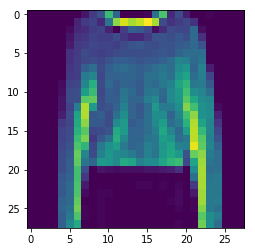

In [4]:
# 构建迭代器，image和label分别自动对应
image, label = next(iter(trainloader))

# 每个image图片中有64张图片，因为之前的batch_size=64，即每次有64份数据。
# 我们查看索引为5的图片吧，嘻嘻:)
seeimage = image[5]
# 转化为28*28的灰度图
seeimagetrans = seeimage.reshape((28,28))
seeimagelabel = label[5]

import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(seeimagetrans)

labellist = ['T恤', '裤子', '套衫', '裙子', '外套', '凉鞋', '汗衫', '运动鞋', '包包', '靴子']
print(f'图片{5}对应的标签是{labellist[seeimagelabel]}')

注意每次迭代器给出的images是不同的64张图，所以重复运行结果不同。

### 数据类型预览

In [5]:
## image
image[1]

tensor([[[-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1

In [6]:
print(image[1].shape)
print(image.shape)

torch.Size([1, 28, 28])
torch.Size([64, 1, 28, 28])


In [7]:
label

tensor([8, 9, 7, 9, 2, 2, 4, 7, 5, 0, 7, 6, 2, 6, 6, 2, 8, 8, 5, 7, 3, 3, 3, 4,
        3, 4, 0, 1, 5, 5, 0, 9, 7, 7, 2, 1, 4, 5, 2, 2, 4, 6, 7, 3, 9, 2, 5, 7,
        2, 9, 8, 8, 7, 3, 7, 8, 2, 3, 4, 6, 6, 7, 8, 0])

可以看到的是image是tensor的列表，28$\times$28的灰度图，label是标签列表组成的tensor。

其中image被标准化到-1和1之间，细看才明白图像边缘应该都差不多（-1），中间会出现重要的特征（非-1）。

## 神经网络训练

### 四层全连接神经网络

In [8]:
from torch import nn, optim
import torch.nn.functional as F

class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)
        
    def forward(self, x):
        # make sure input tensor is flattened
        x = x.view(x.shape[0], -1)
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.log_softmax(self.fc4(x), dim=1)
        
        return x

In [15]:
# 对上面定义的Classifier类进行实例化
model = Classifier()

# 定义损失函数为负对数损失函数
criterion = nn.NLLLoss()

# 优化方法为Adam梯度下降方法，学习率为0.003
optimizer = optim.Adam(model.parameters(), lr=0.003)

# 对训练集的全部数据学习15遍，这个数字越大，训练时间越长
epochs = 15

# 将每次训练的训练误差和测试误差存储在这两个列表里，后面绘制误差变化折线图用
train_losses, test_losses = [], []

print('开始训练')
for e in range(epochs):
    running_loss = 0
    
    # 对训练集中的所有图片都过一遍
    for images, labels in trainloader:
        # 将优化器中的求导结果都设为0，否则会在每次反向传播之后叠加之前的
        optimizer.zero_grad()
        
        # 对64张图片进行推断，计算损失函数，反向传播优化权重，将损失求和
        log_ps = model(images)
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    # 每次学完一遍数据集，都进行以下测试操作
    else:
        test_loss = 0
        accuracy = 0
        # 测试的时候不需要开自动求导和反向传播
        with torch.no_grad():
            # 关闭Dropout
            model.eval()
            
            # 对测试集中的所有图片都过一遍
            for images, labels in testloader:
                # 对传入的测试集图片进行正向推断、计算损失，accuracy为测试集一万张图片中模型预测正确率
                log_ps = model(images)
                test_loss += criterion(log_ps, labels)
                ps = torch.exp(log_ps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                
                # 等号右边为每一批64张测试图片中预测正确的占比
                accuracy += torch.mean(equals.type(torch.FloatTensor))
        # 恢复Dropout
        model.train()
        # 将训练误差和测试误差存在两个列表里，后面绘制误差变化折线图用
        train_losses.append(running_loss/len(trainloader))
        test_losses.append(test_loss/len(testloader))

        print("训练集学习次数: {}/{}.. ".format(e+1, epochs),
              "训练误差: {:.3f}.. ".format(running_loss/len(trainloader)),
              "测试误差: {:.3f}.. ".format(test_loss/len(testloader)),
              "模型分类准确率: {:.3f}".format(accuracy/len(testloader)))

开始训练
训练集学习次数: 1/15..  训练误差: 0.515..  测试误差: 0.442..  模型分类准确率: 0.838
训练集学习次数: 2/15..  训练误差: 0.388..  测试误差: 0.434..  模型分类准确率: 0.841
训练集学习次数: 3/15..  训练误差: 0.355..  测试误差: 0.415..  模型分类准确率: 0.852
训练集学习次数: 4/15..  训练误差: 0.330..  测试误差: 0.408..  模型分类准确率: 0.855
训练集学习次数: 5/15..  训练误差: 0.315..  测试误差: 0.371..  模型分类准确率: 0.866
训练集学习次数: 6/15..  训练误差: 0.304..  测试误差: 0.358..  模型分类准确率: 0.876
训练集学习次数: 7/15..  训练误差: 0.286..  测试误差: 0.377..  模型分类准确率: 0.873
训练集学习次数: 8/15..  训练误差: 0.284..  测试误差: 0.375..  模型分类准确率: 0.867
训练集学习次数: 9/15..  训练误差: 0.275..  测试误差: 0.361..  模型分类准确率: 0.874
训练集学习次数: 10/15..  训练误差: 0.263..  测试误差: 0.378..  模型分类准确率: 0.871
训练集学习次数: 11/15..  训练误差: 0.261..  测试误差: 0.357..  模型分类准确率: 0.876
训练集学习次数: 12/15..  训练误差: 0.252..  测试误差: 0.358..  模型分类准确率: 0.876
训练集学习次数: 13/15..  训练误差: 0.246..  测试误差: 0.366..  模型分类准确率: 0.878
训练集学习次数: 14/15..  训练误差: 0.241..  测试误差: 0.365..  模型分类准确率: 0.877
训练集学习次数: 15/15..  训练误差: 0.239..  测试误差: 0.364..  模型分类准确率: 0.881


以上的代码均来自子豪，我已阅读所有代码。

In [17]:
testloader

一个难办的事情是这些数据集都是加载好的，但是如果想用自己的数据就不太方便。到时候我再看看吧QwQ。

### 测试单个例子

output是tensor([[ -0.7812,  -8.8485,  -5.5040,  -4.9422,  -6.5097, -22.5740,  -0.6363,
         -30.4438,  -9.9643, -33.3823]])
ps是tensor([[4.5784e-01, 1.4360e-04, 4.0703e-03, 7.1389e-03, 1.4889e-03, 1.5713e-10,
         5.2927e-01, 6.0040e-14, 4.7052e-05, 3.1788e-15]])
神经网络猜测图片里是 汗衫，概率为52.927082777023315%


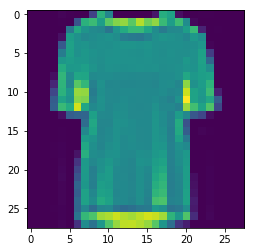

In [18]:
dataiter = iter(testloader)
images, labels = dataiter.next()# 还有一种写法是 image, label = next(iter(trainloader))
img = images[0]
img = img.reshape((28,28)).numpy()# tensor或者array都可以作图哦
plt.imshow(img)


# 将测试图片转为一维的列向量
img = torch.from_numpy(img)
img = img.view(1, 784)

# 进行正向推断，预测图片所在的类别
with torch.no_grad():
    output = model.forward(img)
ps = torch.exp(output)
print(f'output是{output}')
print(f'ps是{ps}')

top_p, top_class = ps.topk(1, dim=1) # topk函数，https://pytorch.org/docs/stable/torch.html?highlight=topk#torch.topk
prediction = labellist[top_class]
probability = float(top_p)
print(f'神经网络猜测图片里是 {prediction}，概率为{probability*100}%')

先要把用于测试的数据转换为一维列向量，且返回的是属于各个类别的概率值

### Loss曲线

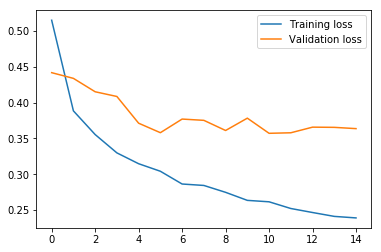

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend()

训练误差持续下降，但是验证集上的误差反复波动，按照子豪的说法，这是过拟合的表现。

为什么呢？留待考察。

为了缓解过拟合的现象，需要使用`Dropout`或者是添加$L_2$正则项，etc。

### Dropout 方法缓解过拟合

In [20]:
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)
        
        # 构造Dropout方法，在每次训练过程中都随机“掐死”百分之二十的神经元，防止过拟合。
        self.dropout = nn.Dropout(p=0.2) # 本来没有这一行
        
    def forward(self, x):
        # 确保输入的tensor是展开的单列数据，把每张图片的通道、长度、宽度三个维度都压缩为一列
        x = x.view(x.shape[0], -1)
        
        # 在训练过程中对隐含层神经元的正向推断使用Dropout方法
        x = self.dropout(F.relu(self.fc1(x))) # dropout是这样用的？？！！
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))
        
        # 在输出单元不需要使用Dropout方法
        x = F.log_softmax(self.fc4(x), dim=1)
        
        return x

In [21]:
# 对上面定义的Classifier类进行实例化
model = Classifier()

# 定义损失函数为负对数损失函数
criterion = nn.NLLLoss()

# 优化方法为Adam梯度下降方法，学习率为0.003
optimizer = optim.Adam(model.parameters(), lr=0.003)

# 对训练集的全部数据学习15遍，这个数字越大，训练时间越长
epochs = 15

# 将每次训练的训练误差和测试误差存储在这两个列表里，后面绘制误差变化折线图用
train_losses, test_losses = [], []

print('开始训练')
for e in range(epochs):
    running_loss = 0
    
    # 对训练集中的所有图片都过一遍
    for images, labels in trainloader:
        # 将优化器中的求导结果都设为0，否则会在每次反向传播之后叠加之前的
        optimizer.zero_grad()
        
        # 对64张图片进行推断，计算损失函数，反向传播优化权重，将损失求和
        log_ps = model(images)
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    # 每次学完一遍数据集，都进行以下测试操作
    else:
        test_loss = 0
        accuracy = 0
        # 测试的时候不需要开自动求导和反向传播
        with torch.no_grad():
            # 关闭Dropout
            model.eval()
            
            # 对测试集中的所有图片都过一遍
            for images, labels in testloader:
                # 对传入的测试集图片进行正向推断、计算损失，accuracy为测试集一万张图片中模型预测正确率
                log_ps = model(images)
                test_loss += criterion(log_ps, labels)
                ps = torch.exp(log_ps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                
                # 等号右边为每一批64张测试图片中预测正确的占比
                accuracy += torch.mean(equals.type(torch.FloatTensor))
        # 恢复Dropout
        model.train()
        # 将训练误差和测试误差存在两个列表里，后面绘制误差变化折线图用
        train_losses.append(running_loss/len(trainloader))
        test_losses.append(test_loss/len(testloader))

        print("训练集学习次数: {}/{}.. ".format(e+1, epochs),
              "训练误差: {:.3f}.. ".format(running_loss/len(trainloader)),
              "测试误差: {:.3f}.. ".format(test_loss/len(testloader)),
              "模型分类准确率: {:.3f}".format(accuracy/len(testloader)))

开始训练
训练集学习次数: 1/15..  训练误差: 0.611..  测试误差: 0.452..  模型分类准确率: 0.838
训练集学习次数: 2/15..  训练误差: 0.479..  测试误差: 0.425..  模型分类准确率: 0.845
训练集学习次数: 3/15..  训练误差: 0.457..  测试误差: 0.443..  模型分类准确率: 0.839
训练集学习次数: 4/15..  训练误差: 0.435..  测试误差: 0.432..  模型分类准确率: 0.845
训练集学习次数: 5/15..  训练误差: 0.422..  测试误差: 0.413..  模型分类准确率: 0.854
训练集学习次数: 6/15..  训练误差: 0.411..  测试误差: 0.415..  模型分类准确率: 0.855
训练集学习次数: 7/15..  训练误差: 0.406..  测试误差: 0.404..  模型分类准确率: 0.865
训练集学习次数: 8/15..  训练误差: 0.401..  测试误差: 0.413..  模型分类准确率: 0.850
训练集学习次数: 9/15..  训练误差: 0.393..  测试误差: 0.397..  模型分类准确率: 0.856
训练集学习次数: 10/15..  训练误差: 0.383..  测试误差: 0.400..  模型分类准确率: 0.865
训练集学习次数: 11/15..  训练误差: 0.380..  测试误差: 0.377..  模型分类准确率: 0.870
训练集学习次数: 12/15..  训练误差: 0.374..  测试误差: 0.369..  模型分类准确率: 0.868
训练集学习次数: 13/15..  训练误差: 0.373..  测试误差: 0.372..  模型分类准确率: 0.870
训练集学习次数: 14/15..  训练误差: 0.375..  测试误差: 0.378..  模型分类准确率: 0.871
训练集学习次数: 15/15..  训练误差: 0.371..  测试误差: 0.375..  模型分类准确率: 0.871


如上所示，这里学习的是怎么样添加`dropout`方法，只需要在神经网络类中进行操作。

不过仅仅看上面的训练结果，dropout 20%带来了波动的准确率，至于效果还要看Loss曲线。

效果如下所示，先看测试单个例子（预计差别不大）；并给出Loss曲线（验证集的误差可能持续下降）。

神经网络猜测图片里是 裤子，概率为100.0%


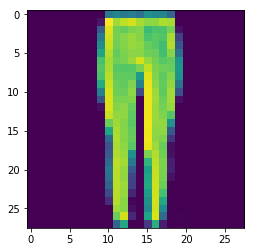

In [22]:
model.eval()
dataiter = iter(testloader)
images, labels = dataiter.next()
img = images[0]
img = img.reshape((28,28)).numpy()
plt.imshow(img)

# 将测试图片转为一维的列向量
img = torch.from_numpy(img)
img = img.view(1, 784)

# 进行正向推断，预测图片所在的类别
with torch.no_grad():
    output = model.forward(img)
ps = torch.exp(output)

top_p, top_class = ps.topk(1, dim=1)
labellist = ['T恤','裤子','套衫','裙子','外套','凉鞋','汗衫','运动鞋','包包','靴子']
prediction = labellist[top_class]
probability = float(top_p)
print(f'神经网络猜测图片里是 {prediction}，概率为{probability*100}%')

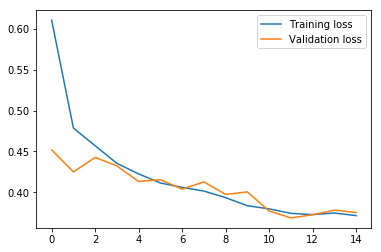

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend()

可以看到，整体的Loss的确是在下降的。

### $L_1$ & $L_2$ 正则化

首先声明这里的方法参考自[知乎](https://zhuanlan.zhihu.com/p/62393636)，但是在CSDN上也看到了一样的文章，我个人对此不作评论。

$L_1$需要手动实现，直接跳过，试水$L_2$吧。目的是大的权重（或者说参数）施加更严重的惩罚，至于有多严重就是靠调参数了。知乎上建议可以用$10^{-4}$或者$10^{-3}$数量级。

在`PyTorch`中，$L_2$正则项反映在优化器，即`optimizer`的参数`weight_decay(float, optional)`上，一般来说默认为0，需要正则的话就去调整它。

In [24]:
from torch import nn, optim
import torch.nn.functional as F

import matplotlib.pyplot as plt
%matplotlib inline

class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)
        
        # 构造Dropout方法，在每次训练过程中都随机“掐死”百分之二十的神经元，防止过拟合。
        self.dropout = nn.Dropout(p=0.2) # 本来没有这一行
        
    def forward(self, x):
        # 确保输入的tensor是展开的单列数据，把每张图片的通道、长度、宽度三个维度都压缩为一列
        x = x.view(x.shape[0], -1)
        
        # 在训练过程中对隐含层神经元的正向推断使用Dropout方法
        x = self.dropout(F.relu(self.fc1(x))) # dropout是这样用的？？！！
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))
        
        # 在输出单元不需要使用Dropout方法
        x = F.log_softmax(self.fc4(x), dim=1)
        
        return x


# 对上面定义的Classifier类进行实例化
model = Classifier()

# 定义损失函数为负对数损失函数
criterion = nn.NLLLoss()

# 优化方法为Adam梯度下降方法，学习率为0.003
optimizer = optim.Adam(model.parameters(), lr=0.003, weight_decay=0.001)

# 对训练集的全部数据学习15遍，这个数字越大，训练时间越长
epochs = 15

# 将每次训练的训练误差和测试误差存储在这两个列表里，后面绘制误差变化折线图用
train_losses, test_losses = [], []

print('开始训练')
for e in range(epochs):
    running_loss = 0
    
    # 对训练集中的所有图片都过一遍
    for images, labels in trainloader:
        # 将优化器中的求导结果都设为0，否则会在每次反向传播之后叠加之前的
        optimizer.zero_grad()
        
        # 对64张图片进行推断，计算损失函数，反向传播优化权重，将损失求和
        log_ps = model(images)
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    # 每次学完一遍数据集，都进行以下测试操作
    else:
        test_loss = 0
        accuracy = 0
        # 测试的时候不需要开自动求导和反向传播
        with torch.no_grad():
            # 关闭Dropout
            model.eval()
            
            # 对测试集中的所有图片都过一遍
            for images, labels in testloader:
                # 对传入的测试集图片进行正向推断、计算损失，accuracy为测试集一万张图片中模型预测正确率
                log_ps = model(images)
                test_loss += criterion(log_ps, labels)
                ps = torch.exp(log_ps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                
                # 等号右边为每一批64张测试图片中预测正确的占比
                accuracy += torch.mean(equals.type(torch.FloatTensor))
        # 恢复Dropout
        model.train()
        # 将训练误差和测试误差存在两个列表里，后面绘制误差变化折线图用
        train_losses.append(running_loss/len(trainloader))
        test_losses.append(test_loss/len(testloader))

        print("训练集学习次数: {}/{}.. ".format(e+1, epochs),
              "训练误差: {:.3f}.. ".format(running_loss/len(trainloader)),
              "测试误差: {:.3f}.. ".format(test_loss/len(testloader)),
              "模型分类准确率: {:.3f}".format(accuracy/len(testloader)))

开始训练
训练集学习次数: 1/15..  训练误差: 0.640..  测试误差: 0.504..  模型分类准确率: 0.821
训练集学习次数: 2/15..  训练误差: 0.544..  测试误差: 0.517..  模型分类准确率: 0.820
训练集学习次数: 3/15..  训练误差: 0.539..  测试误差: 0.497..  模型分类准确率: 0.821
训练集学习次数: 4/15..  训练误差: 0.523..  测试误差: 0.478..  模型分类准确率: 0.827
训练集学习次数: 5/15..  训练误差: 0.520..  测试误差: 0.475..  模型分类准确率: 0.821
训练集学习次数: 6/15..  训练误差: 0.522..  测试误差: 0.461..  模型分类准确率: 0.833
训练集学习次数: 7/15..  训练误差: 0.517..  测试误差: 0.502..  模型分类准确率: 0.810
训练集学习次数: 8/15..  训练误差: 0.508..  测试误差: 0.495..  模型分类准确率: 0.811
训练集学习次数: 9/15..  训练误差: 0.518..  测试误差: 0.504..  模型分类准确率: 0.803
训练集学习次数: 10/15..  训练误差: 0.510..  测试误差: 0.471..  模型分类准确率: 0.833
训练集学习次数: 11/15..  训练误差: 0.506..  测试误差: 0.457..  模型分类准确率: 0.838
训练集学习次数: 12/15..  训练误差: 0.508..  测试误差: 0.478..  模型分类准确率: 0.829
训练集学习次数: 13/15..  训练误差: 0.507..  测试误差: 0.436..  模型分类准确率: 0.842
训练集学习次数: 14/15..  训练误差: 0.503..  测试误差: 0.452..  模型分类准确率: 0.835
训练集学习次数: 15/15..  训练误差: 0.508..  测试误差: 0.492..  模型分类准确率: 0.821


神经网络猜测图片里是 套衫，概率为91.29619002342224%


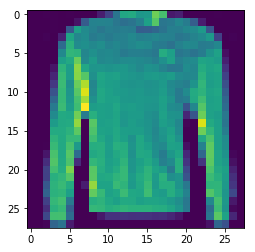

In [26]:
model.eval()
dataiter = iter(testloader)
images, labels = dataiter.next()
img = images[0]
img = img.reshape((28,28)).numpy()
plt.imshow(img)

# 将测试图片转为一维的列向量
img = torch.from_numpy(img)
img = img.view(1, 784)

# 进行正向推断，预测图片所在的类别
with torch.no_grad():
    output = model.forward(img)
ps = torch.exp(output)

top_p, top_class = ps.topk(1, dim=1)
labellist = ['T恤','裤子','套衫','裙子','外套','凉鞋','汗衫','运动鞋','包包','靴子']
prediction = labellist[top_class]
probability = float(top_p)
print(f'神经网络猜测图片里是 {prediction}，概率为{probability*100}%')

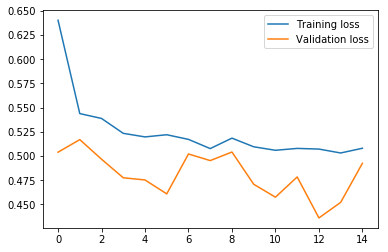

In [28]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend()

惊了，验证集的误差竟然比测试集还低，本来以为两次缓解过拟合会出现学的不太好的情况。